
#The Complex Network Homework No. 1
Bahar Mahdavi - SN: 40152521337

## A. Call the Karate Club graph from the torch_geometric library and visualize  it.

In [2]:
import os
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.1.0+cu121


###The installation of PyTorch Geometric (PyG) on Colab
PyTorch Geometric is an extension library to the popular deep learning framework PyTorch, and consists of various methods and utilities to ease the implementation of Graph Neural Networks.
https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

In [ ]:
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00


###Loading dataset

In [3]:
# Load Zachary's karate club network
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
data = dataset[0]  # Get the first graph object.

ModuleNotFoundError: ignored

###Graph visualization

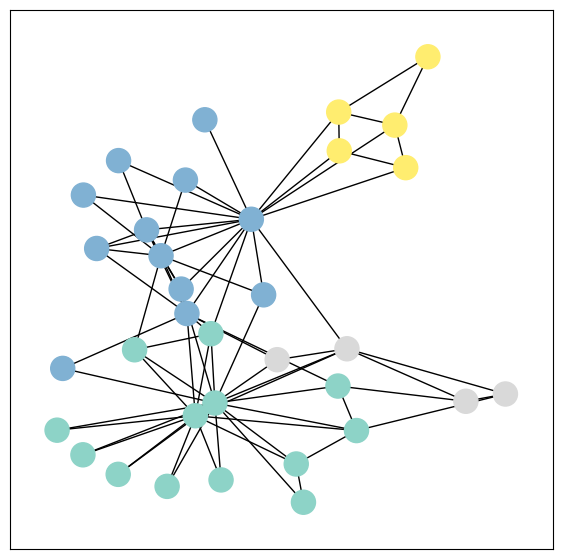

In [ ]:
%matplotlib inline
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

G = nx.karate_club_graph()
G = to_networkx(data, to_undirected=True)
G.remove_edges_from(nx.selfloop_edges(G))

plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=42),
                 with_labels=False,
                 node_color=data.y,
                 cmap="Set3")
plt.show()

## B. Display the graph properties, including the number of nodes and edges, the list of nodes and edges, the number of classes, the labels of nodes, the node feature vectors, and the training data mask.

In [ ]:
print(f'Dataset: {dataset}:') #Zachary's karate club network containing 34 nodes, connected by 156 (undirected and unweighted) edges: This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club
print('======================')
print(data)
print('==============================================================')
# Gather some statistics about the graph.
print(f'Number of graphs: {len(dataset)}') #this dataset holds exactly one graph
print(f'Number of features: {dataset.num_features}') #each node in this dataset is assigned a 34-dimensional feature vector (which uniquely describes the members of the karate club)

##Number of nodes and edges

In [ ]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')

##Edge index

In [ ]:
G.edges

In [ ]:
#In case we used Networkx
edge_index = torch.tensor(list(G.edges))
edge_index = torch.transpose(edge_index, 0,1)
edge_index

In [ ]:
#In case we used PyG
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

##Nodes list

In [ ]:
G.nodes

In [ ]:
for n in G.nodes:
     print(n , '-->', G.nodes[n])

##Number of classes

In [ ]:
print(f'Number of classes: {dataset.num_classes}') #the graph holds exactly 4 classes, which represent the community each node belongs to

##Define labels and display the graph

In [ ]:
#Create edge labels (0 for intra-club edges, 1 for inter-club edges)
edge_labels = [0 if G.nodes[edge[0]]['club'] == G.nodes[edge[1]]['club'] else 1 for edge in G.edges]
edge_labels = torch.tensor(edge_labels, dtype=torch.float)
edge_labels

In [ ]:
x = torch.eye(G.number_of_nodes()) #Feature matrix (one-hot encoded node identity)
print(x.shape)
print(x)

In [ ]:
# there are two labels for nodes; Officer and Mr. Hi. we convert them into binary labels
G = nx.karate_club_graph()
labels = []
for i in G.nodes:
    club_names = G.nodes[i]['club']
    labels.append(1 if club_names== 'Officer' else 0)

In [ ]:
G.remove_edges_from(nx.selfloop_edges(G))
layout_pos = nx.spring_layout(G)
nx.draw_networkx(G, pos = layout_pos , node_color = labels, cmap = 'Set3')

##Mask of training data

In [ ]:
print(f'Number of training nodes: {data.train_mask.sum()}') #mask of training data describes for which nodes we already know their community assigments
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

In [ ]:
data.train_mask

In [ ]:
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #whether there exists isolated nodes in the graph (i.e. there exists no edge to any node)
print(f'Contains self-loops: {data.has_self_loops()}') #whether the graph contains self-loops
print(f'Is undirected: {data.is_undirected()}') #whether the graph is undirected

## C. Train a network comprising graph convolutional layers and a classifier. Utilize the graph convolutional layers to generate node embeddings of length 2 for the nodes of the Karate Club graph, and subsequently classify them using a classifier.

### Model architecture


In [ ]:
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(7531)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        out = self.classifier(h)# Apply a final (linear) classifier.

        return out, h

model = GCN()
print(model)

###Training the model

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

In [ ]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
epochs = 1500
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function (loss criterion).
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Define optimizer.
# Training loop
for epoch in range(epochs):
    loss, h, accuracy = train(data)
    losses.append(loss.item())

In [ ]:
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='c')

plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

###Visualizing node embeddings


In [ ]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y, cmap='Set3', s=50)
plt.xlabel((f'Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=12)
plt.title("Node Embeddings Visualization")

plt.show()

##D. Ramp up the number of graph layers in the aforementioned model to a minimum of 20 layers, and then assess the outcome through visual comparison or examination of numerical features.

### Model architecture

In [ ]:
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(7531)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 4)
        self.conv4 = GCNConv(4, 4)
        self.conv5 = GCNConv(4, 4)
        self.conv6 = GCNConv(4, 4)
        self.conv7 = GCNConv(4, 4)
        self.conv8 = GCNConv(4, 4)
        self.conv9 = GCNConv(4, 4)
        self.conv10 = GCNConv(4, 4)
        self.conv11 = GCNConv(4, 4)
        self.conv12 = GCNConv(4, 4)
        self.conv13 = GCNConv(4, 4)
        self.conv14 = GCNConv(4, 4)
        self.conv15 = GCNConv(4, 4)
        self.conv16 = GCNConv(4, 4)
        self.conv17 = GCNConv(4, 4)
        self.conv18 = GCNConv(4, 4)
        self.conv19 = GCNConv(4, 4)
        self.conv20 = GCNConv(4, 4)
        self.conv21 = GCNConv(4, 4)
        self.conv22 = GCNConv(4, 4)
        self.conv23 = GCNConv(4, 4)
        self.conv24 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.conv4(h, edge_index)
        h = h.tanh()
        h = self.conv5(h, edge_index)
        h = h.tanh()
        h = self.conv6(h, edge_index)
        h = h.tanh()
        h = self.conv7(h, edge_index)
        h = h.tanh()
        h = self.conv8(h, edge_index)
        h = h.tanh()
        h = self.conv9(h, edge_index)
        h = h.tanh()
        h = self.conv10(h, edge_index)
        h = h.tanh()
        h = self.conv11(h, edge_index)
        h = h.tanh()
        h = self.conv12(h, edge_index)
        h = h.tanh()
        h = self.conv13(h, edge_index)
        h = h.tanh()
        h = self.conv14(h, edge_index)
        h = h.tanh()
        h = self.conv15(h, edge_index)
        h = h.tanh()
        h = self.conv16(h, edge_index)
        h = h.tanh()
        h = self.conv17(h, edge_index)
        h = h.tanh()
        h = self.conv18(h, edge_index)
        h = h.tanh()
        h = self.conv19(h, edge_index)
        h = h.tanh()
        h = self.conv20(h, edge_index)
        h = h.tanh()
        h = self.conv21(h, edge_index)
        h = h.tanh()
        h = self.conv22(h, edge_index)
        h = h.tanh()
        h = self.conv23(h, edge_index)
        h = h.tanh()
        h = self.conv24(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        out = self.classifier(h)# Apply a final (linear) classifier.

        return out, h

model = GCN()
print(model)

###Training the model

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

In [ ]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
epochs = 1500
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function (loss criterion).
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Define optimizer.
# Training loop
for epoch in range(epochs):
    loss, h, accuracy = train(data)
    losses.append(loss.item())

In [ ]:
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='c')

plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

###Visualizing node embeddings

In [ ]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y, cmap='Set3', s=50)
plt.xlabel((f'Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=12)
plt.title("Node Embeddings Visualization")

plt.show()

##E. In the general case of excessive increase in the number of graphic layers in the model, what effect can it have on the quality of the embedding?

Increasing the number of graph layers in a GNNs mode can allow it to capture more complex relationships within the graph. However, if the model becomes too deep, it might start memorizing the training graph instead of learning meaningful representations that generalize to new graphs leading to phenomena such as overfitting. This means that the model may learn specific features of the training graph that are  too specialized and fails to generalize well to new graphs. For example, the model may capture intricate patterns in graph structures, node relationships, features or noise in the training graph that do not necessarily apply to other graphs. This can result in a decrease in the model's performance on new graphs.

In general, it's crucial to strike a balance between model complexity and generalization. Simply increasing the number of layers might not always improve performance, as a more complex model could become too tailored to the training data, hindering its ability to adapt to new data. Regularization techniques (e.g., dropout) and careful tuning of hyperparameters can help mitigate overfitting.

##F. Utilizing the Laplacian eigenmap method, compute alternative initial representation vectors for the graph nodes and then proceed to re-evaluate parts C and D with these vectors to verify the outcome.

In [ ]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import dgl
def laplacian_positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
    """

    # Laplacian
    A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float)
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
    L = sp.eye(g.number_of_nodes()) - N * A * N

    # Eigenvectors with scipy
    #EigVal, EigVec = sp.linalg.eigs(L, k=pos_enc_dim+1, which='SR')
    EigVal, EigVec = sp.linalg.eigs(L, k=pos_enc_dim+1, which='SR', tol=1e-2) # for 40 PEs
    EigVec = EigVec[:, EigVal.argsort()] # increasing order
    out = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float()

    return out

In [ ]:
PE_dim = 128
G = to_networkx(data)
adj = nx.to_numpy_array(G)
sp_adj = sp.coo_matrix(adj)
g = dgl.from_scipy(sp_adj)
embeddings = np.array(laplacian_positional_encoding(g, PE_dim))

In [ ]:
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(7531)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        out = self.classifier(h)# Apply a final (linear) classifier.

        return out, h

model = GCN()
print(model)

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

In [ ]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
epochs = 1500
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function (loss criterion).
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Define optimizer.
# Training loop
for epoch in range(epochs):
    loss, h, accuracy = train(data)
    losses.append(loss.item())

In [ ]:
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='c')

plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y, cmap='Set3', s=50)
plt.xlabel((f'Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=12)
plt.title("Node Embeddings Visualization")

plt.show()

In [ ]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import dgl
def laplacian_positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
    """

    # Laplacian
    A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float)
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
    L = sp.eye(g.number_of_nodes()) - N * A * N

    # Eigenvectors with scipy
    #EigVal, EigVec = sp.linalg.eigs(L, k=pos_enc_dim+1, which='SR')
    EigVal, EigVec = sp.linalg.eigs(L, k=pos_enc_dim+1, which='SR', tol=1e-2) # for 40 PEs
    EigVec = EigVec[:, EigVal.argsort()] # increasing order
    out = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float()

    return out

In [ ]:
PE_dim = 128
G = to_networkx(data)
adj = nx.to_numpy_array(G)
sp_adj = sp.coo_matrix(adj)
g = dgl.from_scipy(sp_adj)
embeddings = np.array(laplacian_positional_encoding(g, PE_dim))

In [ ]:
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(7531)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 4)
        self.conv4 = GCNConv(4, 4)
        self.conv5 = GCNConv(4, 4)
        self.conv6 = GCNConv(4, 4)
        self.conv7 = GCNConv(4, 4)
        self.conv8 = GCNConv(4, 4)
        self.conv9 = GCNConv(4, 4)
        self.conv10 = GCNConv(4, 4)
        self.conv11 = GCNConv(4, 4)
        self.conv12 = GCNConv(4, 4)
        self.conv13 = GCNConv(4, 4)
        self.conv14 = GCNConv(4, 4)
        self.conv15 = GCNConv(4, 4)
        self.conv16 = GCNConv(4, 4)
        self.conv17 = GCNConv(4, 4)
        self.conv18 = GCNConv(4, 4)
        self.conv19 = GCNConv(4, 4)
        self.conv20 = GCNConv(4, 4)
        self.conv21 = GCNConv(4, 4)
        self.conv22 = GCNConv(4, 4)
        self.conv23 = GCNConv(4, 4)
        self.conv24 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.conv4(h, edge_index)
        h = h.tanh()
        h = self.conv5(h, edge_index)
        h = h.tanh()
        h = self.conv6(h, edge_index)
        h = h.tanh()
        h = self.conv7(h, edge_index)
        h = h.tanh()
        h = self.conv8(h, edge_index)
        h = h.tanh()
        h = self.conv9(h, edge_index)
        h = h.tanh()
        h = self.conv10(h, edge_index)
        h = h.tanh()
        h = self.conv11(h, edge_index)
        h = h.tanh()
        h = self.conv12(h, edge_index)
        h = h.tanh()
        h = self.conv13(h, edge_index)
        h = h.tanh()
        h = self.conv14(h, edge_index)
        h = h.tanh()
        h = self.conv15(h, edge_index)
        h = h.tanh()
        h = self.conv16(h, edge_index)
        h = h.tanh()
        h = self.conv17(h, edge_index)
        h = h.tanh()
        h = self.conv18(h, edge_index)
        h = h.tanh()
        h = self.conv19(h, edge_index)
        h = h.tanh()
        h = self.conv20(h, edge_index)
        h = h.tanh()
        h = self.conv21(h, edge_index)
        h = h.tanh()
        h = self.conv22(h, edge_index)
        h = h.tanh()
        h = self.conv23(h, edge_index)
        h = h.tanh()
        h = self.conv24(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        out = self.classifier(h)# Apply a final (linear) classifier.

        return out, h

model = GCN()
print(model)

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

In [ ]:
# Lists to store loss and accuracy values
losses = []
accuracies = []
epochs = 1500
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function (loss criterion).
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Define optimizer.
# Training loop
for epoch in range(epochs):
    loss, h, accuracy = train(data)
    losses.append(loss.item())

In [ ]:
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='c')

plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y, cmap='Set3', s=50)
plt.xlabel((f'Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=12)
plt.title("Node Embeddings Visualization")

plt.show()